In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import numpy as np
import pylab as plt
import scipy.stats

In [3]:
def resample_uniform(bounds):
    """This function samples from the bounded region, with typical-set stabilization."""
    N = len(bounds)
    ulo, uhi = bounds.T
    ulo = np.clip(ulo, 0., 1.)
    uhi = np.clip(uhi, 0., 1.)
    width = uhi-ulo
    u_BS = ulo + np.random.rand(N)*width  # bounded samples
    idx_BS = np.argsort(np.argsort(u_BS))
    u_free = np.random.rand(N)  # unb}ounded samples
    u_free_sorted = np.sort(u_free)  # sorted unbounded samples
    u = u_free_sorted[idx_BS]
    return u

def resample(dist, bounds):
    u_bounds = dist.cdf(bounds)
    u = resample_uniform(u_bounds)
    return dist.ppf(u)

def resample_norm(bounds):
    dist = scipy.stats.norm(0, 1)
    return resample(dist, bounds)

In [4]:
def rrfft(a):
    n = len(a)
    c = np.empty(n)
    b = np.fft.rfft(a, norm = 'ortho')
    if n%2 == 0:
        b_real, b_imag = np.real(b), np.imag(b)[1:-1]
        b_real[1:-1] *= 2**0.5
        b_imag *= 2**0.5
    else:
        b_real, b_imag = np.real(b), np.imag(b)[1:]
        b_real[1:] *= 2**0.5
        b_imag *= 2**0.5
    c[0], c[1::2], c[2::2] = b_real[0], b_real[1:], b_imag
    return c

def rirfft(a):
    n = len(a)
    if n%2 == 0:
        b = np.zeros(int(n/2)+1, dtype = np.complex128)
        b[0] += a[0]
        b[1:] += a[1::2]/2**0.5
        b[-1] *= 2**0.5
        b[1:-1] += a[2::2]*1j/2**0.5
    else:
        b = np.zeros(int(n/2)+1, dtype = np.complex128)
        b[0] += a[0]
        b[1:] += a[1::2]/2**0.5
        b[1:] += a[2::2]*1j/2**0.5
    c = np.fft.irfft(b, n, norm = 'ortho')
    return c

In [5]:
def rrfft_torch(a):
    n = a.shape[-1]
    c = torch.empty_like(a)
    b = torch.fft.rfft(a, norm = 'ortho')
    if n%2 == 0:
        b_real, b_imag = torch.real(b), torch.imag(b)[..., 1:-1]
        b_real[..., 1:-1] *= 2**0.5
        b_imag *= 2**0.5
    else:
        b_real, b_imag = torch.real(b), torch.imag(b)[1:]
        b_real[1:] *= 2**0.5
        b_imag *= 2**0.5
    c[..., 0], c[..., 1::2], c[..., 2::2] = b_real[..., 0], b_real[..., 1:], b_imag
    return c

def rirfft_torch(a):
    n = a.shape[-1]
    if n%2 == 0:
        b = torch.zeros(*a.shape[:-1], int(n/2)+1)*1j
        b[..., 0] += a[..., 0]
        b[..., 1:] += a[..., 1::2]/2**0.5
        b[..., -1] *= 2**0.5
        b[..., 1:-1] += a[..., 2::2]*1j/2**0.5
    else:
        b = torch.zeros(*a.shape[:-1], int(n/2)+1)*1j
        b[..., 0] += a[..., 0]
        b[..., 1:] += a[..., 1::2]/2**0.5
        b[..., 1:] += a[..., 2::2]*1j/2**0.5
    c = torch.fft.irfft(b, n, norm = 'ortho')
    return c

## Simulator definition

In [6]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds_n = None, bounds_z = None, Nbins = 100, sigma = .3):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.sigma = sigma
        self.x = np.linspace(-1, 1, Nbins)
        
        self.z_sampler = swyft.RectBoundSampler(
            [stats.uniform(-1, 2),
             stats.uniform(-1, 2),
             stats.uniform(-1, 2)
            ],
            bounds = bounds_z
        )

        if bounds_n is None:
            bounds_n = np.ones((Nbins, 2))*self.sigma*5
            bounds_n[:,0] *= -1
        self.bounds_n = bounds_n
        
    def get_fisher_errors(self):
        err_a = self.sigma/(4*self.Nbins)**0.5
        err_b = self.sigma/sum(4*self.x**2)**0.5
        err_c = self.sigma/sum(4*self.x**4)**0.5
        return err_a, err_b, err_c

    def calc_m(self, a, b, c):
        #return a+b*np.exp(-0.5*(self.x - c)**2/0.1**2)
        return 2*(a+b*self.x+c*self.x**2)
    
    def n_sampler(self):
        n = resample_norm(self.bounds_n/self.sigma)*self.sigma
        return n
        
    def build(self, graph):
        n = graph.node("n", lambda: self.n_sampler())
        z = graph.node("z", self.z_sampler)
        a, b, c = graph.node(['a', 'b', 'c'], lambda z: z, z)        
        m = graph.node("m", self.calc_m, a, b, c)
        d = graph.node("d", lambda m, n: m+rirfft(n), m, n)

### Target observation and open bounds

In [7]:
NBINS = 1000
obs = Simulator(Nbins = NBINS).sample(conditions = {'z': np.array([-0.5, 0.5, 0.0])})
bounds_n = None
bounds_z = None

## Define round simulator

In [8]:
sim = Simulator(Nbins = NBINS, bounds_n = bounds_n, bounds_z = bounds_z)
fish_err = sim.get_fisher_errors()

### Generate training data

In [9]:
samples = sim.sample(3_000)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 64)

  0%|          | 0/3000 [00:00<?, ?it/s]

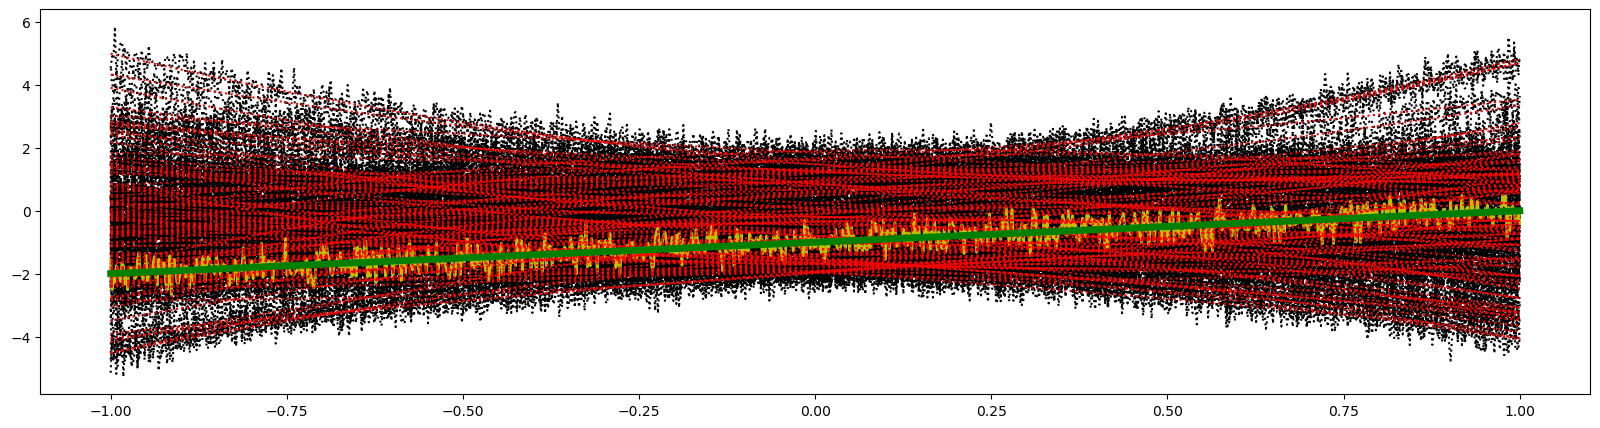

In [10]:
plt.figure(figsize = (20, 5))
for i in range(100):
    plt.plot(sim.x, samples[i]['d'], 'k:')
    plt.plot(sim.x, samples[i]['m'], 'r:', zorder = 100)
plt.plot(sim.x, obs['d'], 'y', lw = 2, zorder = 99)
plt.plot(sim.x, obs['m'], 'g', lw = 5, zorder = 200)
#plt.xlim([-0.1, 0.1])

## Define inference network

In [11]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin_1 = torch.nn.Linear(NBINS, 32)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 32, num_params = 3, varnames = 'z',
                                                       dropout = 0.2, hidden_features = 128)
        self.logratios2 = swyft.LogRatioEstimator_1dim_Gaussian(num_params = NBINS, varnames = 'n')
        self.optimizer_init = swyft.AdamOptimizerInit(lr = 1e-3, lrs_factor = 0.3, lrs_patience = 1)
        
        self.sl = swyft.networks.OnlineStandardizingLayer(shape = (1000,))

    def forward(self, A, B):
        # Estimate signal parameters
        D = A['d']
        
        n = A['n']
        idx = torch.randperm(n.shape[0])
        n = n[idx].view(n.size())
        D = A['m'] + rirfft_torch(n)
        
        D = self.sl(D)
        f = self.lin_1(D)  # data summaries
        logratios1 = self.logratios1(f, B['z'])
        
        # Estimate noise
        df = rrfft_torch(A['d'])
        logratios2 = self.logratios2(df, B['n'])
 
        return logratios1, logratios2

network = Network()

In [12]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [13]:
trainer.fit(network, dm)


  | Name       | Type                            | Params
---------------------------------------------------------------
0 | lin_1      | Linear                          | 32.0 K
1 | logratios1 | LogRatioEstimator_1dim          | 214 K 
2 | logratios2 | LogRatioEstimator_1dim_Gaussian | 0     
3 | sl         | OnlineStandardizingLayer        | 0     
---------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.987     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training ba

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [14]:
prior_samples = sim.sample(10_000, targets = ['z', 'n'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
predictions = trainer.infer(network, obs, prior_samples)

Predicting: 22it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


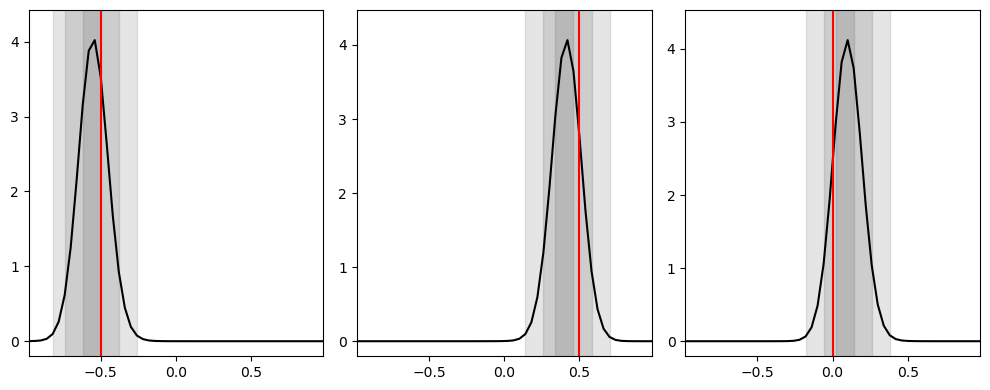

In [16]:
_, axs = plt.subplots(1, 3, figsize = (10, 4))
for i in range(3):
    swyft.plot_1d(predictions, "z[%i]"%i, ax = axs[i], bins=50, smooth = 2)
    axs[i].axvline(obs['z'][i], color='r')
    #axs[i].set_xlim([-1, 1.0])
plt.tight_layout()

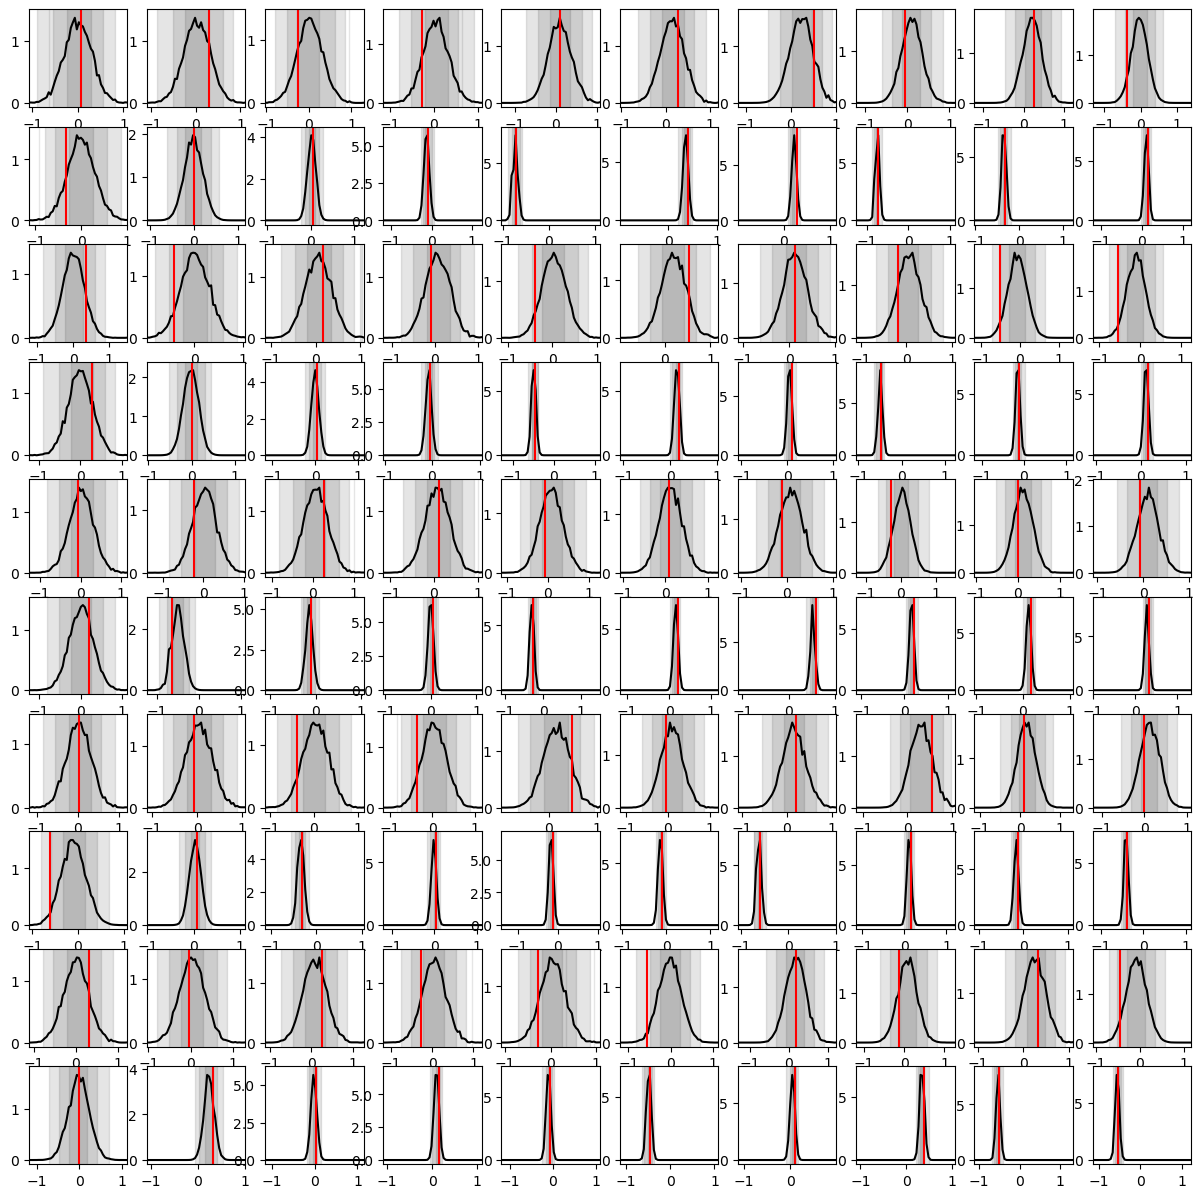

In [17]:
_, axs = plt.subplots(10, 10, figsize = (15, 15))
for i in range(10):
    for j in range(10):
        k = i + j*10
        swyft.plot_1d(predictions, "n[%i]"%k, ax = axs[i][j], bins=50)
        axs[i][j].axvline(obs['n'][k], color='r')

In [203]:
bounds_n = swyft.collect_rect_bounds(predictions[1], 'n', (NBINS,), threshold = 1e-6)
bounds_z = swyft.collect_rect_bounds(predictions[0], 'z', (3,), threshold = 1e-6)
#bounds_z = None

In [204]:
bounds_z

tensor([[-0.5576, -0.4526],
        [ 0.4094,  0.5816],
        [-0.1223,  0.1426]])